# Expedia Hotel Recommendation

Our task is to make hotel recommendations for the users of Expedia which aims to enhance their booking possibilities on Expedia.  
  
Customers who have demands to book a hotel room usually compare hotels’ conditions(eg. Price, location, whether it provides breakfast etc.) on different websites. If Expedia could precisely recommend a specific kind of hotel types that the customers would love to book, the booking rate would enhance. Thus, the revenue of Expedia would also increase which generates business values. 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Course/DS&BD/Project 2')
# os.chdir('/content/drive/My Drive/Big data project 2')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
train = pd.read_csv('train.csv')

In [0]:
test = pd.read_csv("test.csv")

In [0]:
train_original=train

In [0]:
train.shape

(37670293, 24)

In [0]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-27,2014-08-31,2,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,9,2014-08-29,2014-09-02,2,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,9,2014-08-29,2014-09-02,2,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,3,2014-11-23,2014-11-28,2,0,1,14984,1,0,1,2,50,1457,21


In [0]:
train.dtypes

date_time                     object
site_name                      int64
posa_continent                 int64
user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
user_id                        int64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

## **Data Exploring and Feature Engineering**

### Missing Value

In [0]:
train.isna().sum()

date_time                           0
site_name                           0
posa_continent                      0
user_location_country               0
user_location_region                0
user_location_city                  0
orig_destination_distance    13525001
user_id                             0
is_mobile                           0
is_package                          0
channel                             0
srch_ci                         47083
srch_co                         47084
srch_adults_cnt                     0
srch_children_cnt                   0
srch_rm_cnt                         0
srch_destination_id                 0
srch_destination_type_id            0
is_booking                          0
cnt                                 0
hotel_continent                     0
hotel_country                       0
hotel_market                        0
hotel_cluster                       0
dtype: int64

We find that the orig_destination_distance has large volume of missing data, so this columns should be dropped.

### Transform `srch_co` and `srch_ci` in to staying duration



srch_ci and srch_co are the check in and check out date during search, which is hard to fill in. 

We transform them to the duration that they plan to stay in the hotel, then use mean to fill in the data

In [0]:
train['srch_duration'] = pd.to_datetime(train['srch_co'], errors = 'coerce')-pd.to_datetime(train['srch_ci'], errors = 'coerce')

In [0]:
train['srch_duration']=train['srch_duration'].apply(lambda x : str(x).split()[0] if not pd.isnull(x) else x)

In [0]:
train['srch_duration']=train['srch_duration'].astype('int')

In [0]:
train['srch_duration']=train['srch_duration'].apply(lambda x: None if x<0 else x)

In [0]:
train['srch_duration'] = train['srch_duration'].fillna(train['srch_duration'].median())

In [0]:
selected_columns = ["date_time", "site_name", 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city','user_id',
       'is_mobile', 'is_package',
       'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'srch_duration']


In [0]:
train = train[selected_columns]

In [0]:
test['srch_duration'] = pd.to_datetime(test['srch_co'], errors = 'coerce')-pd.to_datetime(test['srch_ci'], errors = 'coerce')

In [0]:
test['srch_duration'].isna().sum()

In [0]:
test['srch_duration']=test['srch_duration'].apply(lambda x : str(x).split()[0] if not pd.isnull(x) else x)

In [0]:
test['srch_duration']=test['srch_duration'].astype('int')

In [0]:
test['srch_duration']=test['srch_duration'].apply(lambda x: None if x<0 else x)
test['srch_duration'] = train['srch_duration'].fillna(test['srch_duration'].median())

In [0]:
test=test[list(set(selected_columns)-set(['hotel_cluster', 'cnt', 'is_booking']))]

### Transform date_time into Year and Month

In [0]:
train.dtypes

From printing out the data types of each column, date_time is object. We would like to change it to year and month column in case they are useful to do classofication.

In [0]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

test["date_time"] = pd.to_datetime(test["date_time"])
train["test"] = train["test"].dt.year
train["test"] = train["test"].dt.month

### Outlier

In [0]:
def visualize_box_plot(column_lst):
    '''
    This function visualizes Box-and-whisker plots for int variables
    '''
    
    for i in column_lst:
        sns.boxplot(train[i])


        plt.show()

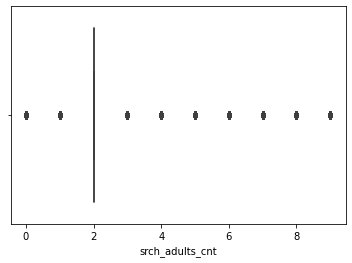

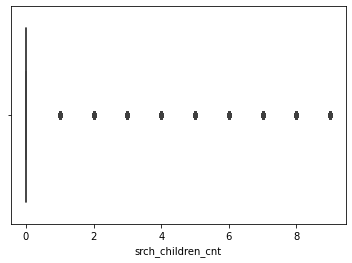

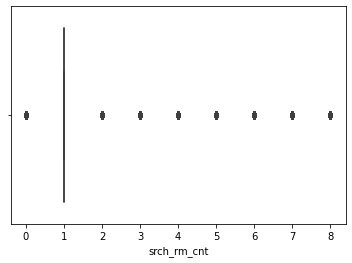

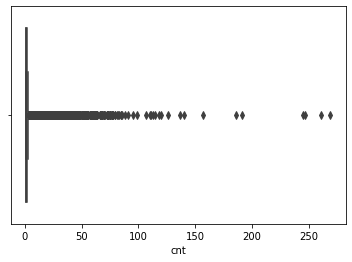

In [0]:
 visualize_box_plot(['srch_adults_cnt','srch_children_cnt', 'srch_rm_cnt', 'cnt' ])

From the box plots showing above, our data is skewed. So it is hard to say these are outliers. We decide to keep all these values.

In [0]:
train.to_csv("train_clean.csv",index=False)

In [0]:
test.to_csv("test_clean.csv",index=False)

## EDA

In [0]:
train=pd.read_csv("train_clean.csv")

In [0]:
test=pd.read_csv("test_clean.csv")

### Corralation between 'hotel_cluster' and other varaibles

In [0]:
train.corr()["hotel_cluster"].sort_values()

srch_destination_type_id   -0.032850
hotel_country              -0.024289
site_name                  -0.022408
is_booking                 -0.021548
hotel_continent            -0.013963
srch_destination_id        -0.011712
user_location_country      -0.010477
srch_rm_cnt                -0.005954
year                       -0.001050
month                      -0.000560
channel                     0.000707
user_location_city          0.000831
user_id                     0.001052
cnt                         0.002944
user_location_region        0.007453
is_mobile                   0.008412
srch_adults_cnt             0.012309
posa_continent              0.014938
srch_children_cnt           0.016261
hotel_market                0.034205
srch_duration               0.038450
is_package                  0.038733
hotel_cluster               1.000000
Name: hotel_cluster, dtype: float64

We observe that `hotel_cluster` is not having strong corralation with other varaibles. This means that using linear regression would not be a good idea to make prediction on this data.

### Distribution of `hotel_cluster`

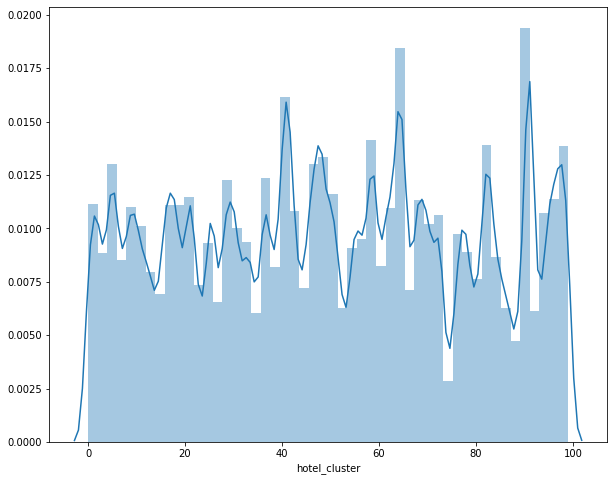

In [0]:
plt.figure(figsize=(10, 8))
sns.distplot(train['hotel_cluster'])

This is the distribution of our lable. We can see that it is not evenly distributed, which is a problem for classification task. As the dataset is very large, we consider to down sample our data to make the data balanced.

### Heatmap for every variables

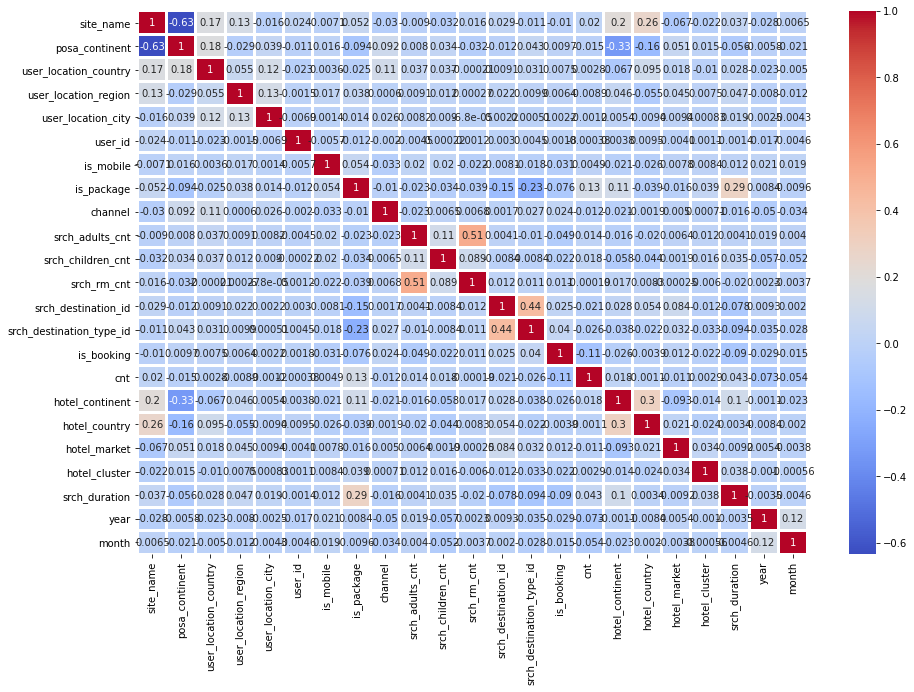

In [0]:
# heatmap
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(train.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

We can find out that `site_name` and `posa_continent` have quite highly negative correlation.  
`srch_adults_cnt` and `srch_rm_cnt` has quite highly positive correlation compared to other features, which is reasonable.

### The Relation of Stay duration and Hotel Cluster 

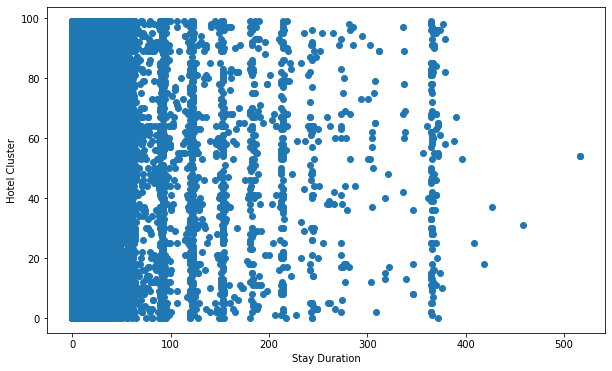

In [0]:
plt.figure(figsize=(10, 6))
plt.scatter(train['srch_duration'], train['hotel_cluster'])
plt.xlabel("Stay Duration")
plt.ylabel("Hotel Cluster")
plt.show()

We can observe that `srch_duration` are mostly smaller than 400 and there's no significant patern between `srch_duration` and `hotel_cluster`.

### The count whether the customer book a hotel

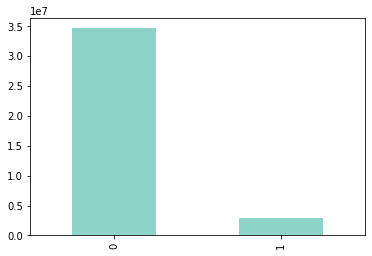

In [0]:
train['is_booking'].value_counts().plot(kind='bar',colormap="Set3")

Most of the users did not book hotel after searching.

### The proportion of customer searching for a package

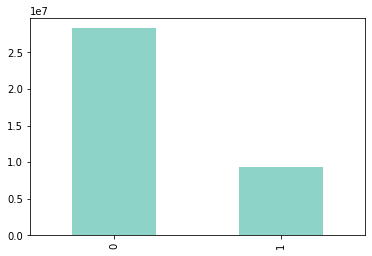

In [0]:
train['is_package'].value_counts().plot(kind='bar',colormap="Set3")

Most of the users aren't searching for pacakge, so they plan to find hotel separately with flights or something else

### Frequency for each `hotel_continent`

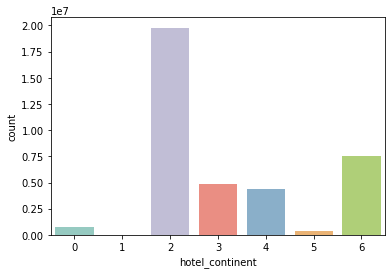

In [0]:
sns.countplot('hotel_continent', data=train, palette="Set3")

Most of the searched hotel is in continent `2`.

### The most popular countries the customer travel from

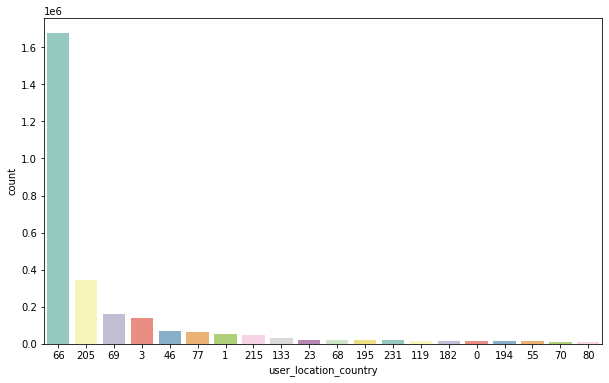

In [0]:
bookings = train[train["is_booking"] == 1]
plt.figure(figsize=(10,6))
sns.countplot('user_location_country',data=bookings, order=bookings.user_location_country.value_counts().iloc[:20].index,palette="Set3")

The plot shows that most of the users who booked a hotel comes from country `66`.

### The most popular countries the customer travel to

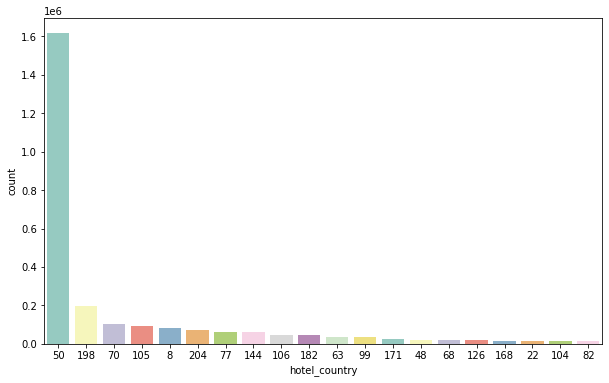

In [0]:
plt.figure(figsize=(10,6))
sns.countplot('hotel_country',data=bookings, order=bookings.hotel_country.value_counts().iloc[:20].index,palette="Set3")

The most popular country that the users go to is country `50`.

### The most popular searching channel

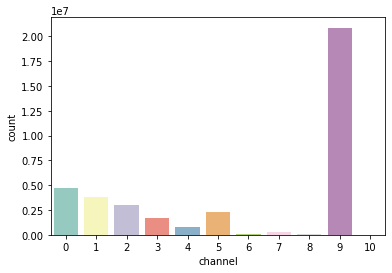

In [0]:
sns.countplot(x='channel', data=train, palette="Set3")

Most of the users are from channel 9, so it is the most impactful channel

### The most popular destination type

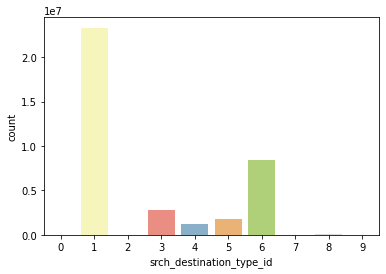

In [0]:
sns.countplot(x='srch_destination_type_id', data=train, palette="Set3")

The most popular destination type is #1

### Explore on number of similar events

<BarContainer object of 2 artists>

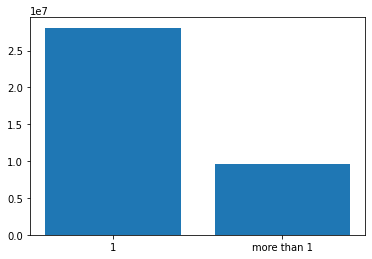

In [0]:
one_cnt = sum([1 if data==1 else 0 for data in train["cnt"]])
more_cnt = sum([1 if data>1 else 0 for data in train["cnt"]])
height = [one_cnt, more_cnt]
plt.bar(['1', 'more than 1'], height)

So, the number of similar events in the context of the same user session are mostly 1

## **Sampling the dataset to a smaller dataset**

Since the dataset is too large to run, we decided to sample it to a smaller dataset.

In [0]:
train=pd.read_csv("train_clean.csv")
dest=pd.read_csv('destinations.csv')
# test=pd.read_csv("test_clean.csv")

In [0]:
train=train[train["is_booking"]==1]

In [0]:
len(train)

3000693

In [0]:
sample_train = train.sample(frac=0.1, random_state=99)
sample_train.shape

(300069, 24)

In [0]:
sample_train= pd.merge(sample_train, dest, how='left', on='srch_destination_id')
sample_train.fillna(0, inplace=True)
sample_train.shape

(300069, 173)

In [0]:
sample_train.to_csv("sample_train_merge_wo_pca.csv",index=False)
# train.to_csv("train_merge.csv",index=False)

## PCA on destination data

Destination data increase 150 columns of our dataset. We used PCA to lower the dimension.

In [0]:
dest=pd.read_csv('destinations.csv')

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
dest_small = pca.fit_transform(dest[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = dest["srch_destination_id"]

In [0]:
dest_small.head()

,0,1,2,srch_destination_id
0,-0.044268,0.169419,0.032523,0
1,-0.440761,0.077405,-0.091572,1
2,0.001033,0.020677,0.012108,2
3,-0.480467,-0.040345,-0.019320,3
4,-0.207253,-0.042694,-0.011744,4


In [0]:
train=pd.read_csv("train_clean.csv")
train=train[train["is_booking"]==1]
sample_train = train.sample(frac=0.1, random_state=99)
sample_train.shape

(300069, 24)

In [0]:
sample_train_pca= pd.merge(sample_train, dest_small, how='left', on='srch_destination_id')
sample_train_pca.fillna(0, inplace=True)

In [0]:
sample_train_pca.shape

(300069, 27)

In [0]:
sample_train_pca.to_csv("sample_train_merge_dest_pca.csv",index=False)

## **Merge with a hotel cluster pivot table to enhance the performance**

By observing the data and also doing some research, we assume that combinations of search destinations, hotel country, hotel market could help us finding the high possibility hotel clusters.

In [0]:
sample_train=pd.read_csv("sample_train_merge_dest_wo_pca.csv")

In [0]:
sample_train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,srch_duration,year,month,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,...,d110,d111,d112,d113,d114,d115,d116,d117,d118,d119,d120,d121,d122,d123,d124,d125,d126,d127,d128,d129,d130,d131,d132,d133,d134,d135,d136,d137,d138,d139,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,2013-09-09 12:42:50,2,3,66,331,54953,369750,0,0,9,1,0,1,12279,6,1,1,2,50,191,72,2.0,2013,9,-2.300724,-2.306053,-2.306053,-2.116478,-1.962514,-1.783918,-2.246499,-2.296689,-2.300400,-2.261573,-2.199644,-2.306053,-2.169948,-2.126119,-2.306053,-1.915019,...,-2.306053,-2.306053,-2.173231,-2.306053,-2.306053,-2.306053,-2.306053,-2.306053,-2.306053,-2.306053,-2.232357,-2.231099,-1.977761,-2.306053,-2.306053,-2.306053,-2.306053,-2.306053,-2.192514,-2.306053,-2.094050,-2.306053,-1.804489,-2.293972,-2.306053,-2.306053,-2.231748,-1.997059,-2.306053,-1.580971,-2.306053,-2.172799,-2.306053,-2.306053,-2.306053,-2.306053,-2.306053,-2.283098,-2.306053,-2.256545
1,2013-03-10 15:09:49,11,3,205,411,54864,342234,0,0,0,4,1,1,12206,6,1,1,2,50,628,19,3.0,2013,3,-2.228747,-2.262795,-2.360155,-2.329214,-2.237640,-1.793412,-2.357969,-2.352442,-2.225186,-2.265767,-2.321278,-2.360155,-2.348140,-1.712616,-2.358729,-1.988857,...,-2.356654,-2.341426,-2.355172,-2.358431,-2.343240,-2.360155,-2.358431,-2.356715,-2.358431,-2.360155,-2.357377,-1.975537,-1.956800,-2.360155,-2.349851,-2.352265,-2.348517,-2.356176,-2.078397,-2.360081,-2.206882,-2.176536,-2.067541,-2.341775,-2.285132,-2.360155,-2.339658,-2.326869,-2.224438,-1.733119,-2.355006,-2.323105,-2.356686,-2.359208,-2.347700,-2.358431,-2.360155,-2.358759,-2.357855,-2.352430
2,2014-03-03 07:10:25,2,3,66,220,28809,637404,0,0,9,2,0,1,289,1,1,1,3,182,53,63,2.0,2014,3,-2.168625,-2.215216,-2.215216,-2.145375,-2.026460,-2.142495,-2.215216,-2.215216,-2.213131,-2.215216,-2.181056,-2.215216,-2.100727,-2.197511,-2.215216,-2.163544,...,-2.215216,-2.215216,-2.215216,-2.215216,-2.032038,-2.215216,-2.215216,-2.215216,-2.215216,-2.215216,-2.215216,-2.143028,-2.188823,-2.215216,-2.215216,-2.215216,-2.213162,-2.215216,-2.082599,-1.968896,-2.212206,-2.213131,-1.923648,-2.215216,-2.215216,-2.215216,-2.215216,-2.194798,-2.215216,-2.104064,-2.213131,-2.099707,-2.215216,-2.215216,-2.185750,-2.215216,-2.215216,-2.215216,-2.215216,-2.153816
3,2014-06-07 08:08:36,37,1,69,695,45017,82046,0,0,9,2,1,2,20198,3,1,1,6,70,1921,62,1.0,2014,6,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-1.849894,-2.208687,-2.208687,-2.208687,-2.208687,-2.188408,-2.208687,-2.208687,-2.208687,-2.208687,-2.054127,...,-2.208687,-2.208687,-2.208687,-2.208687,-2.200329,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.198429,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.049850,-2.208687,-2.061398,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687,-2.208687
4,2014-12-01 19:26:39,11,3,205,411,50761,881850,0,0,9,2,0,1,24606,6,1,1,3,151,80,36,2.0,2014,12,-2.256766,-2.258977,-2.258977,-2.043101,-1.932816,-2.042261,-2.258977,-2.258977,-2.045141,-2.239867,-2.096396,-2.258977,-2.221108,-2.044168,-2.258977,-2.118459,...,-2.258977,-2.256766,-2.258977,-2.258977,-2.228102,-2.258977,-2.258977,-2.258977,-2.258977,-2.258977,-2.258977,-2.196090,-2.139538,-2.258977,-2.258977,-2.258977,-2.242698,-2.258977,-2.093602,-2.029895,-2.258977,-2.194812,-1.857345,-2.258977,-2.164556,-2.228017,-2.258977,-2.183840,-2.258977,-1.814806,-2.256766,-2.194812,-2.258977,-2.258977,-2.258977,-2.258977,-2.258977,-2.248386,-2.258977,-2.258977


In [0]:
pieces = [sample_train.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
4                   7             246          22               1      1
                                               25               5      5
                                               30               1      1
                                               32               2      2
                                               38               1      1

In [0]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,4,7,246,22,0.052632,0.052632,0.052632
1,4,7,246,25,0.263158,0.263158,0.263158
2,4,7,246,30,0.052632,0.052632,0.052632
3,4,7,246,32,0.105263,0.105263,0.105263
4,4,7,246,38,0.052632,0.052632,0.052632


We add a column called sum_count by aggregating sum and counts of hotel clusters in the combination of `srch_destination_id`, `hotel_country`, and `hotel_market`. The purpose of this column is to get a probability of each hotel cluster appears in each combination.

In [0]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,4,7,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052632,NaN,NaN,0.263158,NaN,NaN,NaN,NaN,0.052632,NaN,0.105263,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.105263,NaN,NaN,NaN,0.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN,0.02381,NaN,NaN,NaN,0.047619,0.02381,0.047619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023810,NaN,NaN,0.047619,NaN,NaN,NaN,NaN,NaN
2,9,150,2101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,NaN,NaN,0.071429,NaN,NaN,NaN,NaN,NaN
4,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285714,NaN,NaN,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We then create a pivot table in order to merge with our training data.

In [0]:
sample_train = pd.merge(sample_train, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
sample_train.fillna(0, inplace=True)
sample_train.shape

(300069, 273)

In [0]:
sample_train.to_csv("sample_train_wo_pca.csv",index=False)

## PCA on hotel cluster coulumns

Same reason given above, we do PCA on the new-created hotel cluster columns.

In [0]:
sample_train_merge=pd.read_csv("sample_train_merge_dest_pca.csv")
sample_train_merge.shape

(300069, 27)

In [0]:
agg_pivot.fillna(0, inplace=True)
agg_pivot

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,4,7,246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.052632,0.0,0.0,0.263158,0.0,0.0,0.0,0.0,0.052632,0.0,0.105263,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.105263,0.0,0.0,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,8,50,416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.02381,0.0,0.0,0.0,0.047619,0.02381,0.047619,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.02381,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0
2,9,150,2101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.600000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,11,50,824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0
4,14,27,1434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.142857,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.0,0.00000,0.285714,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17592,64999,50,628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
17593,65020,194,1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
17594,65026,50,550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
17595,65035,105,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.

In [0]:
pca = PCA(n_components=20)
agg_small = pca.fit_transform(agg_pivot[[i for i in range(99)]])
agg_small = pd.DataFrame(agg_small)
agg_small=agg_small.rename(columns={0: "agg_0", 1: "agg_1", 2: "agg_2", 3: "agg_3", 4: "agg_4", 5: "agg_5", 6: "agg_6", 7: "agg_7", 8: "agg_8", 9: "agg_9", \
                                    10: "agg_10", 11: "agg_11", 12: "agg_12", 13: "agg_13", 14: "agg_14", 15: "agg_15", 16: "agg_16", 17: "agg_17", 18: "agg_18", 19: "agg_19"})
agg_small[["srch_destination_id", "hotel_country", 	"hotel_market"]] = agg_pivot[["srch_destination_id", "hotel_country", 	"hotel_market"]]

In [0]:
agg_small.head()

,agg_0,agg_1,agg_2,agg_3,agg_4,agg_5,agg_6,agg_7,agg_8,agg_9,agg_10,agg_11,agg_12,agg_13,agg_14,agg_15,agg_16,agg_17,agg_18,agg_19,srch_destination_id,hotel_country,hotel_market
0,-0.069381,-0.042371,0.017573,-0.037044,-0.063804,-0.040417,-0.019931,0.001705,-0.011973,-0.043491,0.012521,0.081295,0.022784,-0.030939,-0.025592,-0.022350,0.001966,0.042882,0.023650,-0.031232,4,7,246
1,0.002146,0.131546,-0.050248,0.119111,-0.009621,0.040700,0.103831,0.081695,0.106552,0.027467,0.014292,0.003746,0.010494,-0.014279,-0.024913,0.018850,0.008175,0.035593,0.015136,0.007415,8,50,416
2,-0.069051,-0.039906,-0.031729,-0.016686,-0.005420,0.037180,-0.085860,-0.058635,-0.027607,-0.134665,0.128004,-0.087107,-0.067215,0.498565,-0.197762,0.110392,0.039002,0.034966,-0.045891,-0.009118,9,150,2101
3,0.136826,0.161512,-0.027385,0.151790,0.022440,-0.080286,0.043257,0.026066,-0.089997,0.064109,0.026094,0.000003,0.027145,0.007444,-0.004430,0.034924,-0.043245,-0.020172,-0.005628,0.006902,11,50,824
4,-0.068214,-0.039926,-0.026224,-0.022207,-0.002478,0.030162,-0.074641,-0.068692,-0.011990,-0.141273,0.163207,0.129100,0.143500,0.096498,-0.058890,0.049437,0.038934,0.021049,-0.012082,-0.007309,14,27,1434


In [0]:
sample_train_merge = pd.merge(sample_train_merge, agg_small, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
sample_train_merge.shape

(300069, 47)

In [0]:
sample_train_merge.to_csv("sample_train_merge_pca.csv",index=False)

## **Modeling Part**


In [0]:
!pip install ml_metrics

In [0]:
sample_train=pd.read_csv("sample_train_wo_pca.csv")

In [0]:
features_cols_train=list(set(sample_train.columns)-set(["hotel_cluster", "is_booking", "date_time"]))

In [0]:
# features_cols_test = list(set(train.columns)-set(["hotel_cluster", "is_booking", "cnt", "date_time"]))

In [0]:
train_features=sample_train[features_cols_train]
train_labels= sample_train['hotel_cluster']
# test_features=test[features_cols_test]

We find out that the test data given by Expedia does not provide the label(hotel_cluster). Therefore, we train-test split on the training data to evaluate the models we are going to fit in the next section.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( train_features, train_labels, test_size=0.33, random_state=99)

In [0]:
#This is a function used to calculate the accuracy of our model
# If one of the top 5 recommend cluster we provide do match the customer's choice, we count it as accurate
def top_five_accuracy(prediction, truth):
  n=0
  for i in range(len(prediction)):
    for j in prediction[i]:
      if j in truth[i]:
        n+=1
  
  score = n/len(truth)

  return score


### Baseline Model

The baseline model is to use the 5 most common clusters as the predictions. We are going to use this result as our baseline to compare with our other models

In [0]:
sample_train=pd.read_csv("sample_train_wo_pca.csv")

In [0]:
most_common_clusters = list(train_labels.value_counts().head().index)

In [0]:
predictions = [most_common_clusters for i in range(y_test.shape[0])]

In [0]:
import ml_metrics as metrics
target = [[l] for l in y_test]
metrics.mapk(target, predictions, k=5)

0.07211237119995692

In [0]:
top_five_accuracy(predictions, target)

0.13508982761580643

We can see the performance of baseline model is not good. We are going to find ways to improve our model

In [0]:
submission = pd.read_csv("sample_submission.csv")
predictions = [most_common_clusters for i in range(submission.shape[0])]
submission["hotel_cluster"] = predictions
submission.to_csv("submission.csv", index=False)

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=273, max_depth=10)
rf_model=rf.fit(X_train, y_train)
predictions = rf_model.predict_proba(X_test)


In [0]:
rf_model.score(X_train, y_train)

0.21389134824865952

In [0]:
rf_model.score(X_test, y_test)

0.19850943720145825

In [0]:
top_clusters_rf=[]
for i in predictions:
  top_clusters_rf.append(i.argsort()[-5:][::-1].tolist())

In [0]:
metrics.mapk(target, top_clusters_rf, k=5)

0.30789362067398485

In [0]:
top_five_accuracy(top_clusters_rf, target)

0.5090332549003767

### Random Forest after PCA only on Destination

In [0]:
sample_train_pca = pd.read_csv("sample_train_merge_dest_pca.csv")
sample_train_pca.shape

(300069, 27)

In [0]:
sample_train_pca = pd.merge(sample_train_pca, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
sample_train_pca.fillna(0, inplace=True)

In [0]:
features_cols_train=list(set(sample_train_pca.columns)-set(["hotel_cluster", "is_booking", "date_time"]))
train_features_pca=sample_train_pca[features_cols_train]
train_labels_pca= sample_train_pca['hotel_cluster']

In [0]:
train_features_pca.shape

(300069, 124)

In [0]:
X_train, X_test, y_train, y_test = train_test_split( train_features_pca, train_labels_pca, test_size=0.33, random_state=99)

In [0]:
rf = RandomForestClassifier(n_estimators=273, max_depth=10)
rf_model=rf.fit(X_train, y_train)
predictions = rf_model.predict_proba(X_test)

In [0]:
top_clusters_rf=[]
for i in predictions:
  top_clusters_rf.append(i.argsort()[-5:][::-1].tolist())

In [0]:
metrics.mapk(target, top_clusters_rf, k=5)

0.3123770908442147

In [0]:
top_five_accuracy(top_clusters_rf, target)

0.5160316290154813

After PCA on destination, the performance of model has a little bit improvement.

### Random forest after PCA on both Destination and hotel columns

In [0]:
sample_train_pca = pd.read_csv("sample_train_merge_pca.csv")
sample_train_pca.shape

(300069, 47)

In [0]:
features_cols_train=list(set(sample_train_pca.columns)-set(["hotel_cluster", "is_booking", "date_time"]))
train_features_pca=sample_train_pca[features_cols_train]
train_labels_pca= sample_train_pca['hotel_cluster']

In [0]:
train_features_pca.shape

(300069, 44)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( train_features_pca, train_labels_pca, test_size=0.33, random_state=99)

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=273, max_depth=10)
rf_model=rf.fit(X_train, y_train)
predictions = rf_model.predict_proba(X_test)

In [0]:
top_clusters_rf=[]
for i in predictions:
  top_clusters_rf.append(i.argsort()[-5:][::-1].tolist())

In [0]:
import ml_metrics as metrics
target = [[l] for l in y_test]
metrics.mapk(target, top_clusters_rf, k=5)

0.31198088659537015

In [0]:
top_five_accuracy(top_clusters_rf, target)

0.5001262332993345

After PCA on hotel cluster columns, the performance has worsen. Therefore, the best model util now is the Random Forest after PCA only on Destination.

### KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn_model=knn.fit(X_train, y_train)
knn_prob_pred= knn_model.predict_proba(X_test)

In [0]:
knn_model.score(X_train, y_train)

0.2424818200809765

In [0]:
knn_model.score(X_test, y_test)

0.023065348454399483

In [0]:
top_clusters_knn=[]
for i in knn_prob_pred:
  top_clusters_knn.append(i.argsort()[-5:][::-1].tolist())

In [0]:
metrics.mapk(target, top_clusters_knn, k=5)

0.051434683524703026

In [0]:
top_five_accuracy(top_clusters_knn, target)

0.1067327792533048

The performance of KNN model is quite bad compared to the random forest model. Thus, we are not going to do PCA model fit on KNN since the performance can only have slightly change.

### Multiclass Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, multi_class='ovr', )
lr_model=lr.fit(X_train, y_train)
lr_prob_pred= lr_model.predict_proba(X_test)

In [0]:
lr_model.score(X_train, y_train)

0.04818300289485988

In [0]:
lr_model.score(X_test, y_test)

0.049402664027549156

In [0]:
top_clusters_lr=[]
for i in lr_prob_pred:
  top_clusters_lr.append(i.argsort()[-5:][::-1].tolist())

In [0]:
metrics.mapk(target, top_clusters_lr, k=5)

0.08946810336992415

In [0]:
top_five_accuracy(top_clusters_lr, target)

0.16827403734485927

The performance of Multiclass Logistic Regression is also not well.  
We can now first assume that the best classification model of giving recommendation of `hotal cluster` is the random forest model.

### Destination-Based Recommendation

Considering that the search destination are quite related to the hotel clusters, we are going to predict the hotel cluster based on destination

In [0]:
def destination_based_recommendation(data, beta=0.25):
    groups = data.groupby(["srch_destination_id","hotel_cluster"])
    top_clusters = {}
    for name, group in groups:
        clicks = len(group.is_booking[group.is_booking == False])
        bookings = len(group.is_booking[group.is_booking == True])
        score = bookings + beta * clicks
        destination, hotel = name
        if destination in top_clusters:
            top_clusters[destination][hotel] = score
        else:
            top_clusters[destination] = {hotel: score}
    top_clusters_for_destination = {k:[innerk for innerk, innerv in sorted(v.items(), \
    key=lambda x: x[1], reverse=True)[:5]] for k,v in top_clusters.items()}
    return top_clusters_for_destination

In [0]:
top_clusters_for_destination = destination_based_recommendation(sample_train)

In [0]:
predictions = [top_clusters_for_destination[d] if d in top_clusters_for_destination else most_common_clusters
               for d in X_test['srch_destination_id']]

In [0]:
metrics.mapk(target, predictions, k=5)

0.38017699591677356

In [0]:
top_five_accuracy(predictions, target)

0.6184421800995729

In [0]:
# kaggle submission
submission = pd.read_csv("sample_submission.csv")
predictions = [top_clusters_for_destination[d] if d in top_clusters_for_destination else most_common_clusters
               for d in test['srch_destination_id']]
predictions = [str(p)[1:-1].replace(",", " ") for p in predictions]
submission["hotel_cluster"] = predictions
submission.to_csv("submission.csv", index=False)

The item based method performs really well. It is the best model considering both MAP@5 and accuracy.

For this case, we conclude that the destination-based model performs the best.

### Combined with user-based recommendation

Observing the dataset, we can see there are several features related to user. We are going to focus on user_location_country, user_location_region, user_location_city

In [0]:
def user_based_recommendation(data, beta = 0.25):
    groups = data.groupby(["hotel_cluster", 'user_location_country', 'user_location_region', 'user_location_city'])
    top_clusters = {}
    for name, group in groups:
        clicks = len(group.is_booking[group.is_booking == False])
        bookings = len(group.is_booking[group.is_booking == True])
        score = bookings + beta * clicks
        hotel, *user = name
        if str(user) in top_clusters:
            top_clusters[str(user)][hotel] = score
        else:
            top_clusters[str(user)] = {hotel: score}
    top_clusters_for_user = {k:[innerk for innerk, innerv in sorted(v.items(), \
    key=lambda x: x[1], reverse=True)[:5]] for k,v in top_clusters.items()}
    return top_clusters_for_user

In [0]:
top_clusters_for_user = user_based_recommendation(sample_train)

In [0]:
def f5(seq, idfun=None):
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

In [0]:
predictions = []

for index, row in X_test.iterrows():
    pred1 = []
    pred2 = []
    key = [row['user_location_country'], row['user_location_region'], row['user_location_city']]
    if row['srch_destination_id'] in top_clusters_for_destination:
        pred1 = top_clusters_for_destination[row['srch_destination_id']]
    if str(key) in top_clusters_for_user:
        pred2 = top_clusters_for_user[str(key)]
    pred3 = most_common_clusters
    predictions.append(f5(pred1+pred2+pred3)[:5])

In [0]:
metrics.mapk(target, predictions, k=5)

0.38017699591677356

In [0]:
top_five_accuracy(predictions, target)

0.6184421800995729

In [0]:
# kaggle submission
submission = pd.read_csv("sample_submission.csv")
predictions = [top_clusters_for_destination[d] if d in top_clusters_for_destination else most_common_clusters
               for d in test['srch_destination_id']]
predictions = [str(p)[1:-1].replace(",", " ") for p in predictions]
submission["hotel_cluster"] = predictions
submission.to_csv("submission.csv", index=False)

## **Findings and Summary**

*   Most of the users did not book hotels after searching, so precise 
recommendation is really important to enhance booking possibilities
*   The time duration of a customer staying on a website does not correlated to what kind of hotels they would book
*  Most of users are more likely to book the popular(Long-tailed distribution)
*   The destination based recommendation is the simplest method with best performance
*   Destination is an important variable when giving recommendation
*   Our model can predict the users’ taste and provide a good recommendation for users 